In [1]:
import os
import os.path
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from importlib import reload
import adaptive_confound.utils as acu
import adaptive_confound.control as acc
import adaptive_confound.topic_model as actm
import adaptive_confound.confound_detection as accd
import json

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.stats import pearsonr
import pickle
import os.path
import tensorflow as tf
import itertools as it

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 100

from datetime import datetime
from tqdm import tqdm
from sklearn import metrics, preprocessing
from copy import deepcopy
from scipy.stats import mode
from collections import Counter, defaultdict
from tqdm import tqdm_notebook

import keras
from keras import backend as K
from keras.layers import Dense, Input, Lambda, Concatenate, Dropout
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.datasets import reuters
from keras.losses import binary_crossentropy, mse
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
set_session(sess)
sns.set(style="whitegrid")

In [4]:
# read data and pick one strongly biased train/test split.
d = acu.read_pickle("/data/virgile/confound/adaptive/in/twitter_dataset_y=location_z=gender.pkl")
d.create_biased_datasets(1000, [.1,.5,.9], k=1)
d_tr = d.biased_datasets[3]
d_te = d.biased_datasets[-2]
print('corr diff=%.2f' % (d_tr.pearsonr[0] - d_te.pearsonr[0]))

corr diff=-0.81


## Control for training/testing set in ABOW

In [ ]:
# ABOW where z=train vs test
# FIXME: didn't run this one yet...-awc
abow = acc.A_BOW(d.features.size,
                 2, # dim of z, set  to 1
                 hx=500, ht=200, hc=200,
                 use_last_epoch_model=False, checkpoint_dir="/data/culotta/checkpointing/nbs", use_ensemble_model=True,
                 n=11, p=.1, yz_weight_ratio=1, inv_factor=1,
                 optimizer="sgd", z_loss="categorical_crossentropy", z_activation="softmax")
abow.fit_domain_adaptation(d_tr, d_te, 100)
ypred_da = abow.label_clf.predict(d_te.X).round().flatten().astype(int)
metrics.f1_score(d_te.y, ypred_da)

  2%|▏         | 2/100 [00:20<17:38, 10.80s/it]

## Control for true z set in ABOW

In [10]:
# ABOW where z=true gender
abow_truez = acc.A_BOW(d.features.size,
                 1, # dim of z, set  to 1
                 hx=500, ht=200, hc=200,
                 use_last_epoch_model=False, checkpoint_dir="/data/culotta/checkpointing/nbs", use_ensemble_model=True,
                 n=11, p=.1, yz_weight_ratio=1, inv_factor=1,
                 optimizer="sgd", z_loss="binary_crossentropy", z_activation="sigmoid")
abow_truez.fit(d_tr, epochs=100)
ypred_truez = abow_truez.label_clf.predict(d_te.X).round().flatten().astype(int)
metrics.f1_score(d_te.y, ypred_truez)

Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 17.1855 - y_loss: 0.6579 - z_loss: 1.1271
Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: 16.5338 - y_loss: 0.5509 - z_loss: 0.7766
Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: 16.2402 - y_loss: 0.4186 - z_loss: 0.8063
Epoch 4/100
1000/1000 [==============================] - 4s 4ms/step - loss: 15.9473 - y_loss: 0.3477 - z_loss: 0.7726
Epoch 5/100
1000/1000 [==============================] - 4s 4ms/step - loss: 15.6359 - y_loss: 0.2730 - z_loss: 0.7216
Epoch 6/100
1000/1000 [==============================] - 4s 4ms/step - loss: 15.3967 - y_loss: 0.2652 - z_loss: 0.6736
Epoch 7/100
1000/1000 [==============================] - 4s 4ms/step - loss: 15.2351 - y_loss: 0.3048 - z_loss: 0.6534
Epoch 8/100
1000/1000 [==============================] - 4s 4ms/step - loss: 14.9093 - y_loss: 0.1863 - z_loss: 0.6250
Epoch 9/100
1000/1000 [=========================

1000/1000 [==============================] - 4s 4ms/step - loss: 7.2237 - y_loss: 0.0479 - z_loss: 0.6416
Epoch 70/100
1000/1000 [==============================] - 4s 4ms/step - loss: 7.1555 - y_loss: 0.0554 - z_loss: 0.6477
Epoch 71/100
1000/1000 [==============================] - 4s 4ms/step - loss: 7.0684 - y_loss: 0.0514 - z_loss: 0.6452
Epoch 72/100
1000/1000 [==============================] - 4s 4ms/step - loss: 7.2705 - y_loss: 0.3172 - z_loss: 0.6613
Epoch 73/100
1000/1000 [==============================] - 4s 4ms/step - loss: 6.9048 - y_loss: 0.0696 - z_loss: 0.6212
Epoch 74/100
1000/1000 [==============================] - 4s 4ms/step - loss: 6.8201 - y_loss: 0.0508 - z_loss: 0.6329
Epoch 75/100
1000/1000 [==============================] - 4s 4ms/step - loss: 7.0001 - y_loss: 0.2858 - z_loss: 0.6543
Epoch 76/100
1000/1000 [==============================] - 5s 5ms/step - loss: 6.6544 - y_loss: 0.0523 - z_loss: 0.6173
Epoch 77/100
1000/1000 [==============================] - 5s 

0.88166214995483283

## Control for predicted z in ABOW
$z \in \{0,1,2\}$
where 2=has male term, 0=has female term, 1=neither

In [5]:
# ABOW where z = [0,1,2] where
# 2=has male term, 0=has female term, 1=neither
def get_correls(X, y):
    """
    correlations of X and y
    """
    y = np.array(y)
    X = X.toarray()
    return np.array([pearsonr(X[:,i], y)[0] for i in range(X.shape[1])])

def print_top_terms_by_correl(X, y, feats, n=15):
    correls = get_correls(X, y)
    sums = X.sum(axis=0).A1
    correls[np.where(sums < 100)] = 0
    print('pos correl:')
    for ci in np.argsort(correls)[::-1][:n]:
        print('%d: %s %.3f' % (ci, feats[ci], correls[ci]))
    print('neg correl:')
    for ci in np.argsort(correls)[:n]:
        print('%d: %s %.3f' % (ci, feats[ci], correls[ci]))
        
print_top_terms_by_correl(d_tr.X, d_tr.z, d_tr.features, n=30)

pos correl:
1225: angeles 0.365
5942: dodgers 0.336
11041: lakers 0.326
11642: los 0.312
10941: kobe 0.312
3094: burbank 0.281
5941: dodger 0.280
4081: clippers 0.276
18067: socal 0.268
5688: diego 0.267
20668: usc 0.263
16878: san 0.258
9381: hollywood 0.255
3246: california 0.252
11643: losangeles 0.252
20382: ucla 0.247
12694: monica 0.240
21743: xbox 0.237
3189: ca 0.235
1189: anaheim 0.234
20769: vegas 0.233
11224: lebron 0.233
3343: canyon 0.232
5840: disneyland 0.231
11197: league 0.215
13063: nba 0.213
12160: mayweather 0.213
13549: oakland 0.212
21159: warriors 0.210
6805: espn 0.208
neg correl:
13590: obsessed -0.329
13512: nyc -0.312
13306: nj -0.306
21881: york -0.303
13510: ny -0.301
7633: flowers -0.297
12984: nails -0.293
2936: brooklyn -0.284
5111: cutest -0.279
12980: nail -0.279
9147: heels -0.275
18025: snow -0.271
8486: gorgeous -0.265
15164: princess -0.260
21757: xoxo -0.259
8491: gossip -0.259
6149: dresses -0.257
6146: dress -0.248
11881: makeup -0.245
2748: boy

In [7]:
feats = d_tr.features
word2i = {f:i for i,f in enumerate(feats)}
sums = d_tr.X.sum(axis=0).A1
sums[word2i['espn']]

252

In [8]:
# specify top male/female terms
# and train ABOW

male_terms = ['espn']# , 'xbox', 'nba', 'league']
female_terms = ['makeup']# , 'flowers', 'nails', 'cutest', 'heels', 'gorgeous', 'makeup']
malei = np.array([word2i[w] for w in male_terms])
femalei = np.array([word2i[w] for w in female_terms])
male_instances = d_tr.X[:,malei].max(axis=1).nonzero()[0]
female_instances = d_tr.X[:,femalei].max(axis=1).nonzero()[0]
overlap = set(male_instances) & set(female_instances)
print('%d overlap' % len(overlap))
# remove users with both male and female words.
male_instances = np.array(list(set(male_instances) - overlap))
female_instances = np.array(list(set(female_instances) - overlap))
print('true male_counts for male term', Counter(d_tr.z[male_instances]))
print('true female_counts for female term', Counter(d_tr.z[female_instances]))

def make_zhat(i, male_instances, female_instances):
    if i in male_instances:
        return 2
    elif i in female_instances:
        return 0
    else:
        return 1

zhat = np.array([make_zhat(i, male_instances, female_instances) for i in range(len(d_tr.z))])
print('zhat counts', Counter(zhat))
abow_predz = acc.A_BOW(d.features.size,
                 3, # dim of z, set to 3 for [0,1,2] labels.
                 hx=500, ht=200, hc=200,
                 use_last_epoch_model=False, checkpoint_dir="/data/culotta/checkpointing/nbs", use_ensemble_model=True,
                 n=11, p=.1, yz_weight_ratio=1, inv_factor=1,
                 optimizer="sgd", z_loss="categorical_crossentropy", z_activation="softmax")
d_tr2 = deepcopy(d_tr)
d_tr2.z = keras.utils.to_categorical(zhat, 3)
abow_predz.fit(d_tr2, epochs=100)
ypred_predz = abow_predz.label_clf.predict(d_te.X).round().flatten().astype(int)
metrics.f1_score(d_te.y, ypred_predz)

72 overlap
male_counts Counter({1: 135, 0: 45})
female_counts Counter({0: 167, 1: 55})
zhat counts Counter({1: 598, 0: 222, 2: 180})
Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 17.8213 - y_loss: 0.6850 - z_loss: 1.7398
Epoch 2/100
1000/1000 [==============================] - 4s 4ms/step - loss: 17.1710 - y_loss: 0.5316 - z_loss: 1.4365
Epoch 3/100
1000/1000 [==============================] - 4s 4ms/step - loss: 16.7387 - y_loss: 0.4795 - z_loss: 1.2469
Epoch 4/100
1000/1000 [==============================] - 4s 4ms/step - loss: 16.3490 - y_loss: 0.3619 - z_loss: 1.1625
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 16.0622 - y_loss: 0.3195 - z_loss: 1.1034
Epoch 6/100
1000/1000 [==============================] - 4s 4ms/step - loss: 15.7481 - y_loss: 0.2242 - z_loss: 1.0675
Epoch 7/100
1000/1000 [==============================] - 4s 4ms/step - loss: 15.5278 - y_loss: 0.1893 - z_loss: 1.0631
Epoch 8/100
1000/1000 [===========

1000/1000 [==============================] - 5s 5ms/step - loss: 7.5415 - y_loss: 0.0208 - z_loss: 0.9377
Epoch 69/100
1000/1000 [==============================] - 4s 4ms/step - loss: 7.4556 - y_loss: 0.0209 - z_loss: 0.9347
Epoch 70/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.3706 - y_loss: 0.0209 - z_loss: 0.9319
Epoch 71/100
1000/1000 [==============================] - 4s 4ms/step - loss: 7.2858 - y_loss: 0.0206 - z_loss: 0.9284
Epoch 72/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.2119 - y_loss: 0.0206 - z_loss: 0.9345
Epoch 73/100
1000/1000 [==============================] - 4s 4ms/step - loss: 7.1269 - y_loss: 0.0205 - z_loss: 0.9287
Epoch 74/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.0446 - y_loss: 0.0209 - z_loss: 0.9239
Epoch 75/100
1000/1000 [==============================] - 4s 4ms/step - loss: 6.9579 - y_loss: 0.0209 - z_loss: 0.9142
Epoch 76/100
1000/1000 [==============================] - 4s 

0.81262327416173563

In [9]:
# compare LR
from sklearn.linear_model import LogisticRegression
ypred_lr = LogisticRegression().fit(d_tr.X, d_tr.y).predict(d_te.X)
metrics.f1_score(d_te.y, ypred_lr)

0.78486055776892427

### Aron Stopped Here....

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [ ]:
rpath = "abow_domain_adaptation.jsonl"
for d_tr, d_te in tqdm(list(it.product(d.iterate_biased_datasets("train"), d.iterate_biased_datasets("test")))):
    abow.fit_domain_adaptation(d_tr, d_te, 200)
    ypred = abow.label_clf.predict(d_te.X).round().flatten().astype(int)
    with open(rpath, "a") as fd:
        r = dict(
            tr_corr = d_tr.pearsonr[0],
            te_corr = d_te.pearsonr[0],
            ytrue = d_te.y.tolist(),
            ypred = ypred.tolist()
        )
        print(json.dumps(r), file=fd)

In [5]:
df = pd.read_json("./abow_domain_adaptation.jsonl", orient="records", lines=True)

In [6]:
df["f1"] = df.apply(lambda r: metrics.f1_score(r.ytrue, r.ypred), axis=1)
df["corr_diff"] = df.tr_corr - df.te_corr
df["corr_diff_round"] = df.corr_diff.round(1)
df.drop(["ypred", "ytrue"], axis=1, inplace=True)

In [7]:
df["model"] = "ABOW"

Run LR

In [128]:
from sklearn.linear_model import LogisticRegression

In [12]:
df.head()

,te_corr,tr_corr,f1,corr_diff,corr_diff_round,model
0,-0.822216,-0.776347,0.897087,0.045869,0.0,ABOW
1,-0.016131,-0.776347,0.740000,-0.760217,-0.8,ABOW
2,0.790019,-0.776347,0.668675,-1.566367,-1.6,ABOW
3,-0.822216,0.015811,0.712579,0.838027,0.8,ABOW
4,-0.016131,0.015811,0.883895,0.031942,0.0,ABOW


In [13]:
lr = LogisticRegression()
lr_results = []
for d_tr in tqdm(d.iterate_biased_datasets("train")):
    lr.fit(d_tr.X, d_tr.y)
    for d_te in tqdm(d.iterate_biased_datasets("test"), leave=False):
        ypred = lr.predict(d_te.X)
        lr_results.append(dict(
            te_corr = d_te.pearsonr[0],
            tr_corr = d_tr.pearsonr[0],
            model = "LR",
            corr_diff = d_tr.pearsonr[0] - d_te.pearsonr[0],
            corr_diff_round = np.around(d_tr.pearsonr[0] - d_te.pearsonr[0], 1),
            f1 = metrics.f1_score(d_te.y, ypred)
        ))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.07s/it]
0it [00:00, ?it/s]
2it [00:02,  1.10s/it]
0it [00:00, ?it/s]
3it [00:03,  1.07s/it]


In [18]:
lr_df = pd.DataFrame(lr_results)

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


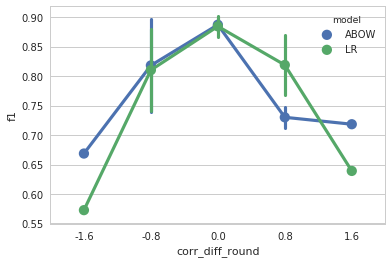

In [21]:
sns.pointplot("corr_diff_round", "f1", data=pd.concat([df, lr_df]), hue="model")

## Study word importance in ABOW for domain adaptation

Fit the A+BOW model for domain adaptation on a pair of datasets exhibiting high confounding shift.

In [203]:
abow = acc.A_BOW(d.features.size,
                 2,
                 hx=500, ht=200, hc=200,
                 use_last_epoch_model=False, checkpoint_dir="/data/culotta/checkpointing/nbs", use_ensemble_model=True,
                 n=11, p=.1, yz_weight_ratio=1, inv_factor=1,
                 optimizer="sgd", z_loss="categorical_crossentropy", z_activation="sigmoid")
#                  z_loss="binary_crossentropy", z_activation="sigmoid")

In [204]:
abow.fit_domain_adaptation(d_tr, d_te, 200)



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:04<15:41,  4.73s/it]
                                       
100%|██████████| 200/200 [02:18<00:00,  1.46it/s]
                                                 

NameError: name 'd' is not defined

In [207]:
f1s, precs, recs = [], [], []
for i in tqdm(range(200)):
    mpath = abow.cpt_name.format(epoch=i)
    abow.model.load_weights(mpath)
    ypred = abow.label_clf.predict(d_te.X).round().astype(int).flatten()
    f1s.append(metrics.f1_score(d_te.y, ypred))
    precs.append(metrics.precision_score(d_te.y, ypred))
    recs.append(metrics.recall_score(d_te.y, ypred))

100%|██████████| 200/200 [00:38<00:00,  5.21it/s]


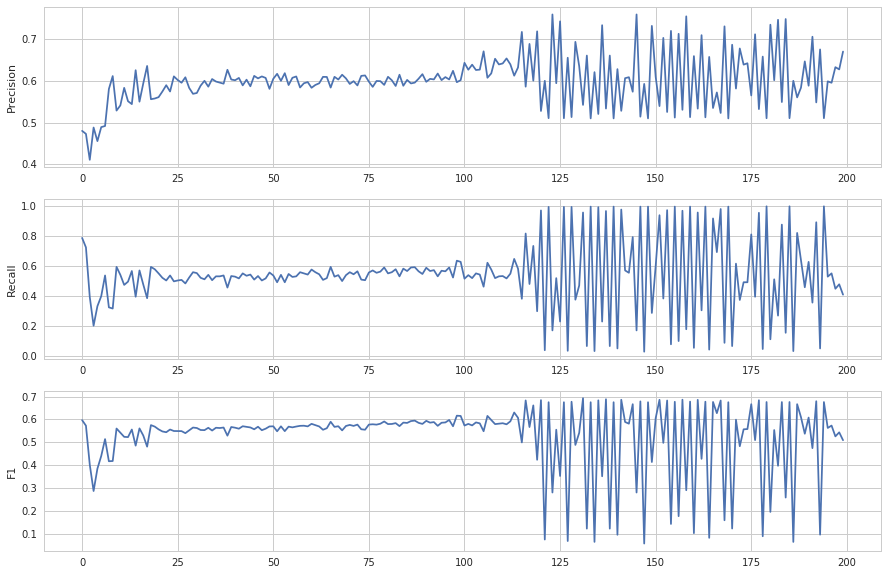

In [224]:
fig, ax = plt.subplots(3, figsize=(15,10))
ax[0].plot(precs)
ax[0].set_ylabel("Precision")
ax[1].plot(recs)
ax[1].set_ylabel("Recall")
ax[2].plot(f1s)
ax[2].set_ylabel("F1");

In [228]:
i = 113 #np.argmax(f1s)
f1s[i], precs[i], recs[i]

(0.6303724928366762, 0.6122448979591837, 0.6496062992125984)

In [229]:
abow.model.load_weights(abow.cpt_name.format(epoch=113))

Compute the activation value of each hidden unit in the network for documents with a unique word.

In [230]:
def get_unit_distrib(inp, weights, biases):
    x = inp
    for w, b in tqdm(list(zip(weights, biases))):
        x = x.dot(w) + b
    return x

In [231]:
ws = abow.domain_clf.get_weights()[::2]
bs = abow.domain_clf.get_weights()[1::2]

In [232]:
k = 21982
uniq_words = np.eye(21981)[:k]
words = d.features[:k]
hidden_unit_distrib = get_unit_distrib(uniq_words, ws[:2], bs[:2])

100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Plot an example with words correlated strongly with y, z, or both.

In [233]:
keep_words = ["nyc", "la", "makeup", "nba"]
hist_keep_words = hidden_unit_distrib[np.hstack([
    np.where(d.features == _) for _ in keep_words
])[0]]

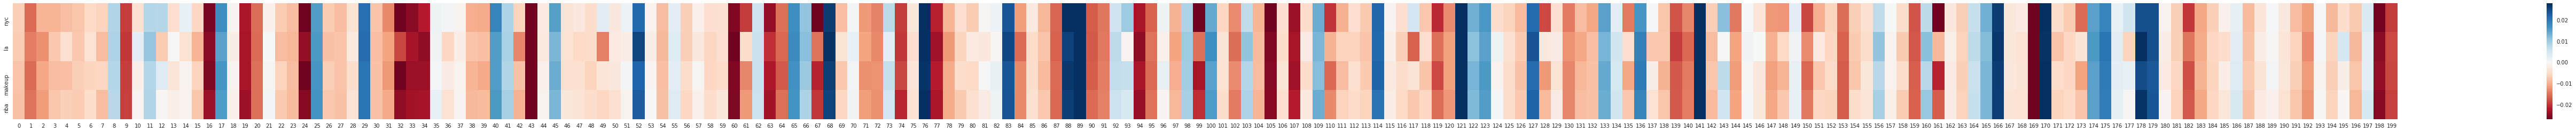

In [234]:
fig, ax = plt.subplots(figsize=(100, 4))#int(.1*hidden_unit_distrib.shape[0])))
sns.heatmap(hist_keep_words, robust=True, center=0, ax=ax, cmap="RdBu",
            yticklabels=keep_words)
fig.savefig("hidden_unit_per_word.png", box_inches="tight")

Cluster the words given the activation values of the hidden unites

In [235]:
from sklearn.cluster import KMeans

In [327]:
kmeans = KMeans(n_clusters=10)
clusters_kmeans = kmeans.fit_predict(hidden_unit_distrib)
scores_kmeans = kmeans.transform(hidden_unit_distrib)

In [328]:
def print_clusters(clusters, scores, features):
    plt.hist(clusters_kmeans);
    for c in np.unique(clusters):
        print("Cluster {:d}".format(c))
        in_c = np.where(clusters == c)[0]
        c_scores = scores[in_c, c]
        
        sort_idx_low = c_scores.argsort()[:30]
        sort_idx_high = scores[:,c].argsort()[::-1][:30]
        
        low_fts = features[in_c][sort_idx_low]
        low_scores = c_scores[sort_idx_low]
        high_fts = features[sort_idx_high]
        high_scores = scores[sort_idx_high, c]
        
        for lf, ls, hf, hs in zip(low_fts, low_scores, high_fts, high_scores):
            print("\t- {:.<25} {:5f}\t {:.<25} {:5f}".format(lf, ls, hf, hs))

In [343]:
def plot_pca(X_pca, clusters, features):
    fig, ax = plt.subplots(figsize=(15,15))
    colors = sns.color_palette(palette="muted", n_colors=10)
    # sns.palettes.diverging_palette(0, 180, n=10)
    markers = ["x", "s", "o", "v"]
    for i, c in enumerate(np.unique(clusters)):
        in_c = clusters == c
        pca0, pca1 = X_pca[in_c,0], X_pca[in_c,1]
        ax.scatter(pca0, pca1, c=colors[i], marker=markers[i % len(markers)],
                   alpha=.3, label="Cluster {}".format(i))
        pca0mi, pca0Mi = pca0.argmin(), pca0.argmax()
        pca1mi, pca1Mi = pca1.argmin(), pca1.argmax()
        pca_fts = features[in_c]
        for pca_idx in [pca0mi, pca0Mi, pca1mi, pca1Mi]:
            ax.annotate(pca_fts[pca_idx], (pca0[pca_idx], pca1[pca_idx]))
    plt.legend()
    return fig, ax

Cluster 0
	- commissioner............. 0.006934	 california............... 0.037499
	- zack..................... 0.007034	 los...................... 0.036508
	- hotter................... 0.007223	 san...................... 0.035383
	- purge.................... 0.007246	 la....................... 0.034939
	- rubber................... 0.007278	 disneyland............... 0.034861
	- spell.................... 0.007279	 angeles.................. 0.034684
	- betch.................... 0.007303	 nyc...................... 0.032510
	- extending................ 0.007305	 ny....................... 0.029907
	- andres................... 0.007305	 ca....................... 0.029762
	- drawn.................... 0.007365	 vegas.................... 0.027565
	- abused................... 0.007371	 york..................... 0.027268
	- desk..................... 0.007384	 hollywood................ 0.026980
	- gurl..................... 0.007389	 brooklyn................. 0.026885
	- protesters...............

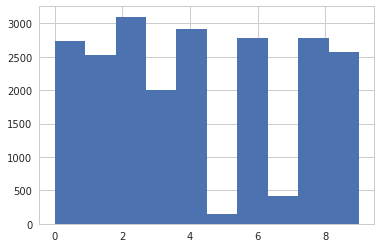

In [330]:
print_clusters(clusters_kmeans, scores_kmeans, d.features)

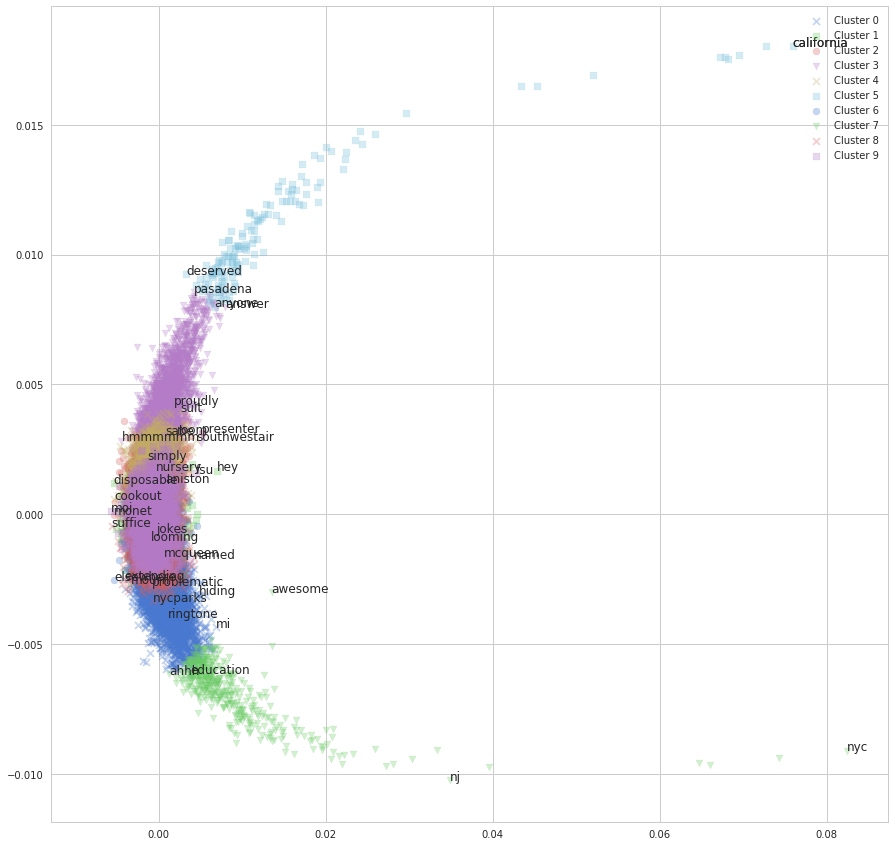

In [344]:
from sklearn.decomposition import PCA
pca = PCA(2)
X_pca = pca.fit_transform(scores_kmeans)

fig, ax = plot_pca(X_pca, clusters_kmeans, d.features)
fig.savefig("cluster_pca_one_word.png")

Same process for pairs of words

In [239]:
from scipy.stats import pearsonr

Select words that are highly correlated with y or z and choose a set of random words.

In [332]:
k_words = 250
top_y_corr_idx = np.abs(y_corr).argsort()[::-1][:k_words]
top_z_corr_idx = np.abs(z_corr).argsort()[::-1][:k_words]
random_words = np.random.choice(range(d.features.size), size=k_words*2, replace=False)

Compute all pairs of words using the previously selected words and build a sparse matrix where one document contains only two words.

In [333]:
all_pairs = list(it.combinations(np.hstack([top_y_corr_idx, top_z_corr_idx, random_words]), 2))

In [334]:
data, row_ind, col_ind, pair_vocab = [], [], [], []
for i, (w1, w2) in enumerate(all_pairs):
    data.extend([1, 1])
    row_ind.extend([i, i])
    col_ind.extend([w1, w2])
    pair_vocab.append("+".join(d.features[[w1, w2]]))

In [335]:
X_pair = sp.csr_matrix((data, (row_ind, col_ind)), shape=(len(all_pairs), d.features.size))

In [336]:
X_pair.shape

(499500, 21981)

In [337]:
hidden_unit_distrib_pair = get_unit_distrib(X_pair, ws[:2], bs[:2])

100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


In [352]:
%%time
kmeans = KMeans(n_clusters=10)
all_hidden_unit_distrib = np.vstack([hidden_unit_distrib, hidden_unit_distrib_pair])
clusters_kmeans_pair = kmeans.fit_predict(all_hidden_unit_distrib)
scores_kmeans_pair = kmeans.transform(all_hidden_unit_distrib)

CPU times: user 4min 22s, sys: 25.2 s, total: 4min 47s
Wall time: 4min 13s


In [353]:
vocabulary = np.hstack( [ d.features, pair_vocab ] )

Cluster 0
	- commissioner............. 0.006949	 los+california........... 0.071013
	- zack..................... 0.007039	 california+san........... 0.069830
	- spell.................... 0.007121	 california+san........... 0.069830
	- betch.................... 0.007355	 disneyland+california.... 0.069240
	- slept.................... 0.007376	 california+la............ 0.069216
	- desk..................... 0.007383	 angeles+california....... 0.069144
	- purge.................... 0.007388	 california+angeles....... 0.069144
	- abused................... 0.007391	 los+san.................. 0.068773
	- andres................... 0.007395	 los+san.................. 0.068773
	- homeland................. 0.007462	 san+san.................. 0.068747
	- sliding.................. 0.007472	 los+la................... 0.068280
	- rubber................... 0.007475	 disneyland+los........... 0.068234
	- handwriting.............. 0.007479	 los+angeles.............. 0.068096
	- proposal.................

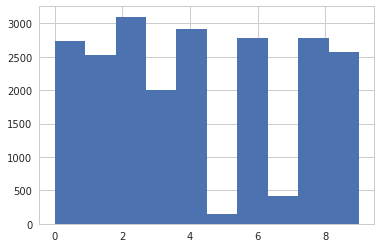

In [354]:
print_clusters(clusters_kmeans_pair, scores_kmeans_pair, vocabulary)

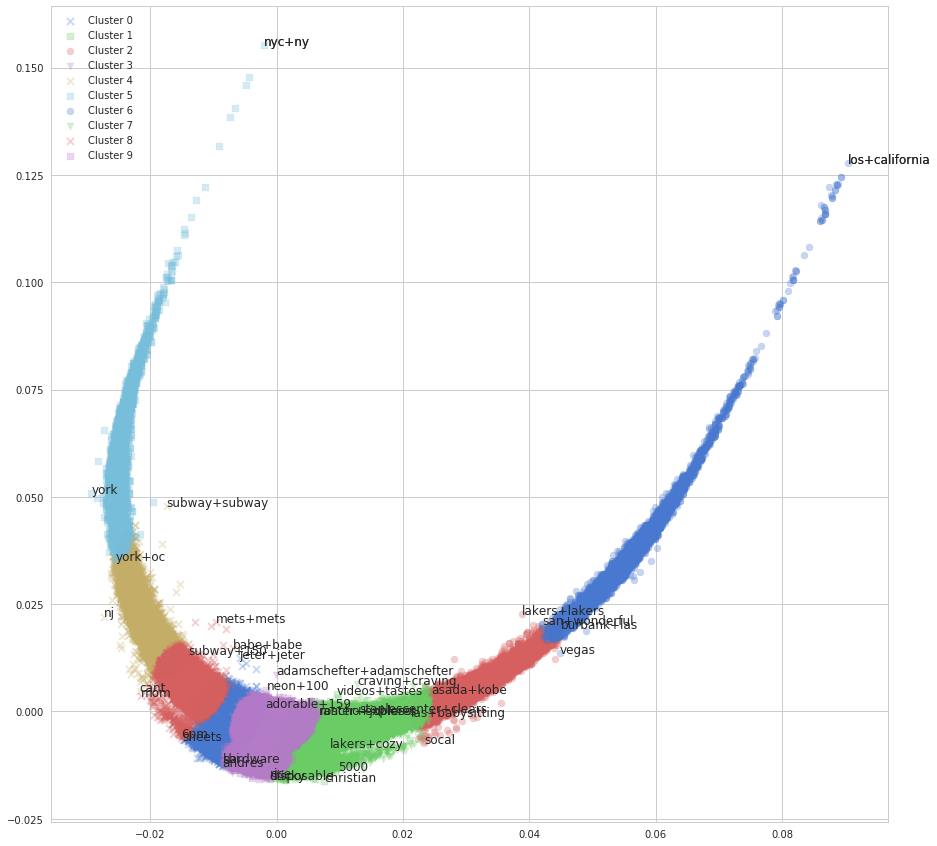

In [355]:
from sklearn.decomposition import PCA
pca = PCA(2)
X_pca = pca.fit_transform(scores_kmeans_pair)

fig, ax = plot_pca(X_pca, clusters_kmeans_pair, vocabulary)
fig.savefig("cluster_pca.png")